In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [2]:
print(tf.__version__)

2.13.0


In [3]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


3670


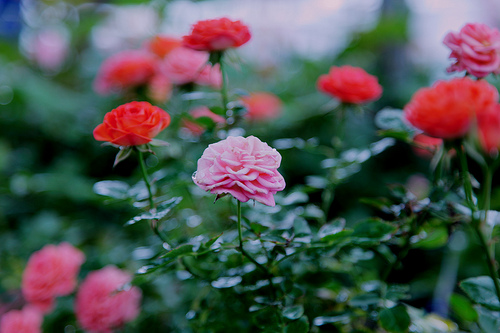

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [6]:
batch_size = 32
img_height = 180
img_width = 180

train dataset

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


validation data

In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
#class_names 속성을 통해 클래스의 이름을 찾을 수 있다.
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


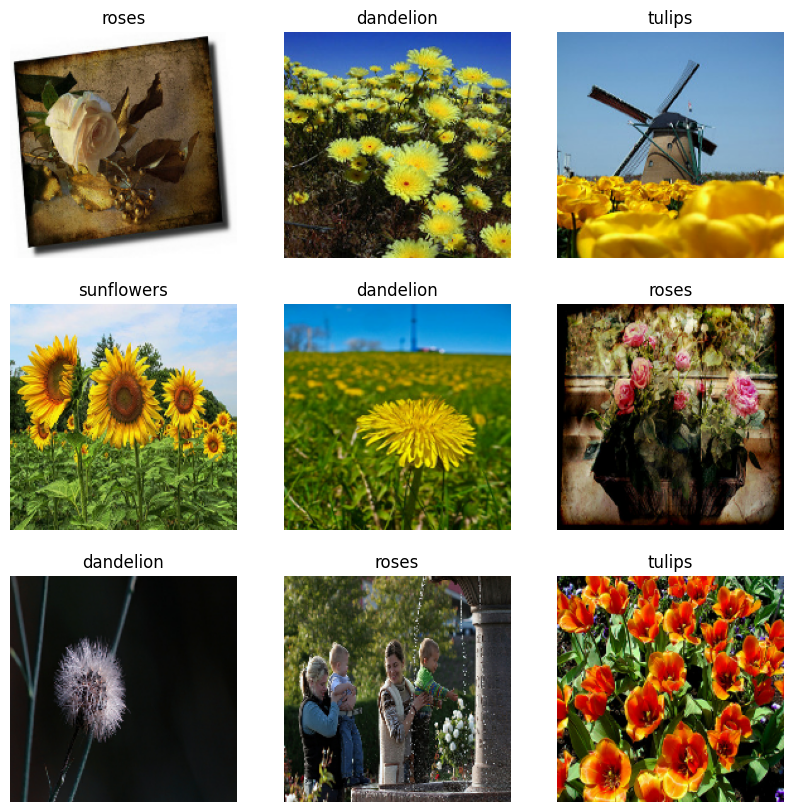

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
# RGB의 채널 값은 [0,255] 범위에 존재한다.
# 입력값을 작게 만들어야 하기 때문에 [0,1]의 범위로 표준화한다.

normalization_layer = tf.keras.layers.Rescaling(1./255)

In [13]:
# 위 레이어를 사용하는 방법은 두가지가 존재한다.
# Dataset.map 호출하기
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

모델 훈련하기

In [15]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [16]:
# tf.keras.optimizers.Adam 옵티마이저 
# tf.keras.losses.SparseCategoricalCrossentropy 손실 함수를 선택합니다.
# 각 훈련 epoch에 대한 훈련 및 검증 정확도를 보려면 metrics 인수를 Model.compile에 전달하세요.

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [17]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
92/92 [==============================] - 19s 205ms/step - loss: 1.3497 - accuracy: 0.4186 - val_loss: 1.1326 - val_accuracy: 0.5708
Epoch 2/10
92/92 [==============================] - 18s 199ms/step - loss: 1.0645 - accuracy: 0.5715 - val_loss: 1.0134 - val_accuracy: 0.5995
Epoch 3/10
92/92 [==============================] - 18s 197ms/step - loss: 0.8993 - accuracy: 0.6553 - val_loss: 0.9583 - val_accuracy: 0.6185
Epoch 4/10
92/92 [==============================] - 19s 204ms/step - loss: 0.7260 - accuracy: 0.7197 - val_loss: 0.9902 - val_accuracy: 0.5995
Epoch 5/10
92/92 [==============================] - 19s 210ms/step - loss: 0.5474 - accuracy: 0.7956 - val_loss: 1.0236 - val_accuracy: 0.6335
Epoch 6/10
92/92 [==============================] - 20s 213ms/step - loss: 0.4042 - accuracy: 0.8535 - val_loss: 1.0230 - val_accuracy: 0.6594
Epoch 7/10
92/92 [==============================] - 20s 216ms/step - loss: 0.3473 - accuracy: 0.8767 - val_loss: 1.2851 - val_accuracy: 0.6090

파일 경로를 (img, label) 쌍으로 변환하는 간단한 함수를 작성합니다.

In [23]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [24]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [25]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

미세 제어를 위해 tf.data 사용하기


In [18]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [19]:
for f in list_ds.take(5):
  print(f.numpy())

b'/Users/woongjae/.keras/datasets/flower_photos/roses/7455236056_b6d71a8dab.jpg'
b'/Users/woongjae/.keras/datasets/flower_photos/tulips/6187740107_9813ccc41e.jpg'
b'/Users/woongjae/.keras/datasets/flower_photos/dandelion/4944731313_023a0508fd_n.jpg'
b'/Users/woongjae/.keras/datasets/flower_photos/tulips/3991423020_9aaf2b5974_n.jpg'
b'/Users/woongjae/.keras/datasets/flower_photos/tulips/4624404489_11e10fcd33_n.jpg'


In [20]:
#파일의 트리 구조를 이용하여 class_name을 컴파일 할 수 있다

class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [21]:
# 데이터세트를 학습 및 검증 세트로 분할합니다.

val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [22]:
# 각각의 데이터 셋 사이즈 확인하기

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [26]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [27]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  4


In [28]:
# 이 데이터셋으로 모델을 훈련시키려면 데이터에 필요한 것이 있다.

#잘 섞고, 배치 처리하고, 가능한 빨리 배치를 사용할 수 있어야 한다.

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

데이터 시각화 하기

2023-07-19 16:48:38.948389: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


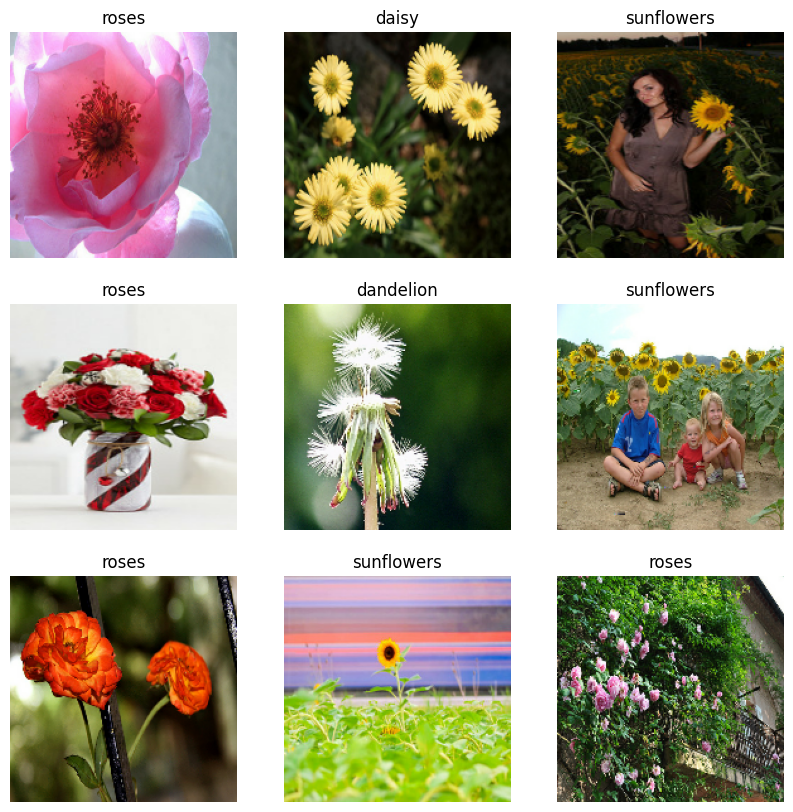

In [29]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")